In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils import *

In [37]:
N = 1000
all_data = []
for i in range(N):
    r1 = np.random.rand(1)
    r2 = np.random.rand(1)
    # if r1 + r2 < 1:
    #     label = 0
    if r1 ** 2 < r2:
        label = 0
    else:
        label = 1
    all_data.append([torch.tensor([r1, r2]), label])

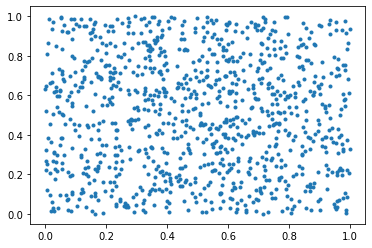

In [38]:
plt.plot([all_data[i][0][0] for i in range(N)], [all_data[i][0][1] for i in range(N)], '.')

In [39]:
train_data = all_data[:N*8//10]
test_data = all_data[N*8//10:]
batch_size = 20
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [40]:
output1 = 10

model = nn.Sequential(
    nn.Linear(2, output1),
    nn.ReLU(),
    nn.Linear(output1, 1)
)

In [41]:
from tqdm.notebook import tqdm, trange

epochs = 200
num_of_params = get_n_params(model)


optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

effective_ranks = []

for epoch in trange(epochs):
    row_counter = 0
    tensor = torch.zeros((len(train_loader),num_of_params))
    for points, labels in train_loader:
        
        optimizer.zero_grad()

        x = points[:,:,0].float()
        # print(x.shape)
        labels = labels[:,None].double()

        y = model(x)
        loss = criterion(y, labels)
        
        loss.backward()
        optimizer.step()

        tensor[row_counter, :] = flatten_and_together([param.grad for param in list(model.parameters())])
        row_counter += 1

    effective_ranks.append(effective_rank(tensor))
    

Text(0, 0.5, 'Effective rank')

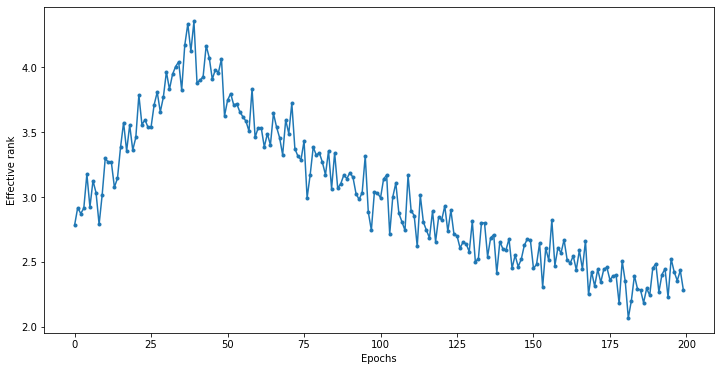

In [42]:
from matplotlib.pyplot import figure

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(6)

plt.plot(effective_ranks, '.-')
plt.xlabel("Epochs")
plt.ylabel("Effective rank")


In [43]:
correct_test = 0
with torch.no_grad():
        # Iterate through test set minibatchs 
        for numbers2, labels2 in test_loader:
            numbers2 = numbers2
            labels2 = labels2.double()[:,None]
            # Forward pass
            x2 = numbers2[:,:,0].float()
            y2 = model(x2)
            predictions2 = ((y2>0)*1)
            # print(predictions2)
            # print(labels2)
            correct_test += torch.sum((predictions2 == labels2).float())
            # print(correct_test)
print(f'Test accuracy: {correct_test/len(test_data)}')


Test accuracy: 0.9549999833106995


In [44]:
tensor = torch.tensor([[-7.9811e-01,  4.2888e-01],[ 1,  0.0000e+00]])
effective_rank(tensor)

tensor(1.6498)

In [45]:
tensor = torch.tensor([1/2, 3/4])
model(tensor)

tensor([-5.3763], grad_fn=<AddBackward0>)